In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError

from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]
lr = 0.001

# Load data
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
dl_test = dl_info_test["dataloader"]

In [3]:
# Model training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data, target in dataloader:
                x_train = data.float().to(device)
                y_train = target[:,:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [4]:
from torch.utils.data import DataLoader, TensorDataset

data = torch.from_numpy(np.load("output/stock_ground_truth_data_24_train.npy")).to(device)
target = torch.from_numpy(np.load("output/stock_ground_truth_target_24_train.npy")).to(device)
train_dataset = TensorDataset(data, target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori = nn.MSELoss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, train_loader, criterion_ori, optimizer_ori, num_epochs=1000, description="Original")

Original loss: 0.000069:  80%|███████▉  | 3997/5000 [01:49<00:27, 36.65it/s]

In [ ]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, target, mean, std in dataloader:
            x_test = data.float().to(device)
            y_test = target[:,:,0].float().to(device)
            mean = mean[:,:,0].float().to(device)
            std = std[:,:,0].float().to(device)
            y_pred = model(x_test)
            total_loss += criterion(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean
            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss /= len(dataloader.dataset)
    predictions = np.concatenate(predictions)
    true_vals = np.concatenate(true_vals)
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss, mape_loss, predictions, true_vals

In [ ]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_target_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_target_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_target_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
loss_ori, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)

print(f"Test loss on original data: {loss_ori:0.5f}")
print(f"Test MAPE loss on original data: {mape_loss_ori:0.5f}")


Test loss on original data: 0.95648
Test MAPE loss on original data: 0.02127


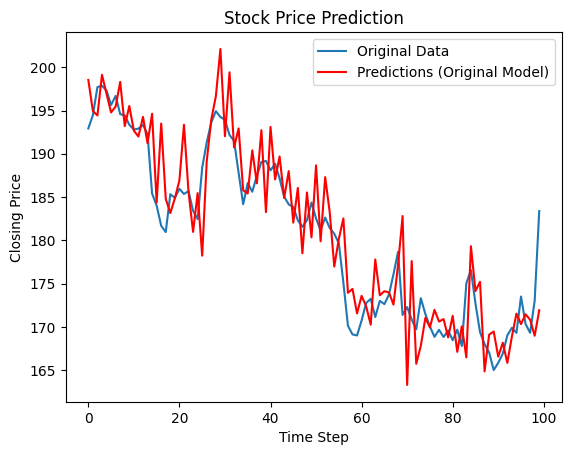

In [ ]:
# Visualize predictions
plt.figure()
plt.plot(true_y[-100:], label='Original Data')
plt.plot(pred_y_ori[-100:], label='Predictions (Original Model)', linestyle='-', color='r')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


In [9]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori = nn.MSELoss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=300, description="Original")

  0%|          | 0/300 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [4]:
# Train on synthetic data
model_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_fake = nn.MSELoss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)
train_model(model_fake, fake_dl, criterion_fake, optimizer_fake, num_epochs=300, description="Synthetic")

Synthetic loss: 0.012086: 100%|██████████| 300/300 [00:07<00:00, 40.98it/s]


Original loss: 0.002043: 100%|██████████| 300/300 [00:07<00:00, 41.33it/s]


In [6]:
# train on original + synthetic data
model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori_fake = nn.MSELoss()
optimizer_ori_fake = optim.Adam(model_ori_fake.parameters(), lr=lr)
train_model(model_ori_fake, fake_dl, criterion_ori_fake, optimizer_ori_fake, num_epochs=300, description="Synthetic")
train_model(model_ori_fake, ori_dl, criterion_ori_fake, optimizer_ori_fake, num_epochs=300, description="Original")

Original loss: 0.000613: 100%|██████████| 300/300 [00:07<00:00, 42.02it/s]


In [7]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [8]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :seq_length - 1, :].float().to(device)
            y_test = data[:, seq_length - 1, 0].view(-1, 1).float().to(device)
            mean = mean[:, -1, 0].view(-1, 1).float().to(device)
            std = std[:, - 1, 0].view(-1, 1).float().to(device)
            y_pred = model(x_test)
            total_loss += criterion(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss /= len(dataloader.dataset)
    predictions = np.concatenate(predictions)
    true_vals = np.concatenate(true_vals)
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss, mape_loss, predictions, true_vals

In [9]:
loss_ori, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
loss_fake, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_ori_fake, test_loader)

print(f"Test loss on original data: {loss_ori:0.5f}")
print(f"Test MAPE loss on original data: {mape_loss_ori:0.5f}")
print(f"Test loss on synthetic data: {loss_fake:0.5f}")
print(f"Test MAPE loss on synthetic data: {mape_loss_fake:0.5f}")

Test loss on original data: 0.00237
Test MAPE loss on original data: 0.00121
Test loss on synthetic data: 0.00220
Test MAPE loss on synthetic data: 0.00120


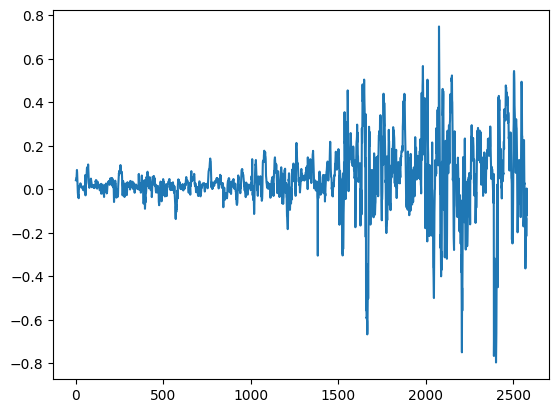

In [25]:
plt.figure()
plt.plot(true_y-pred_y_fake, label='Original Data')
plt.show()


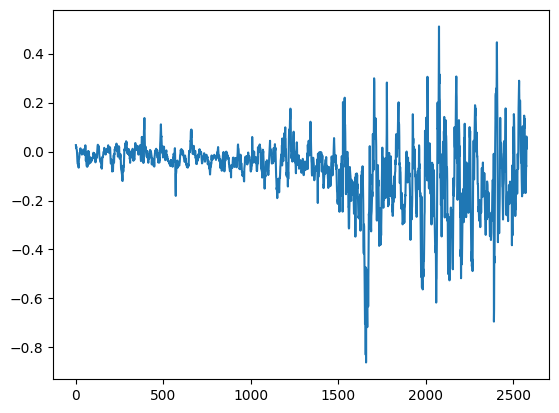

In [26]:
plt.figure()
plt.plot(true_y-pred_y_ori, label='Original Data')
plt.show()


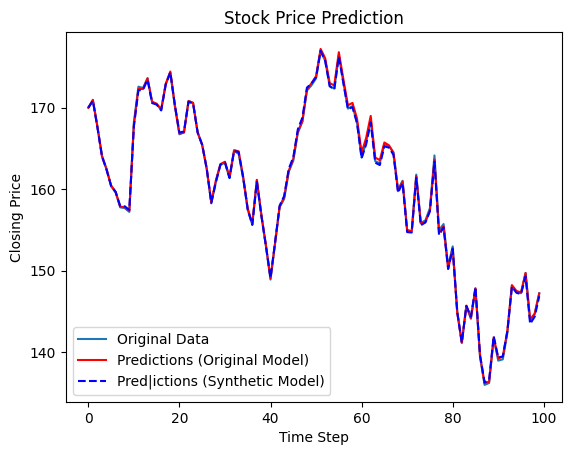

In [23]:
# Visualize predictions
plt.figure()
plt.plot(true_y[2000:2100], label='Original Data')
plt.plot(pred_y_ori[2000:2100], label='Predictions (Original Model)', linestyle='-', color='r')
plt.plot(pred_y_fake[2000:2100], label='Pred|ictions (Synthetic Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


In [11]:
import FinanceDataReader as fdr
raw_df = fdr.DataReader('AAPL, MSFT, NVDA, AMZN, COST', "20000101", "20241231")


In [27]:
raw_df

,AAPL,MSFT,NVDA,AMZN,COST
Date,,,,,
2000-01-03,0.846127,36.065563,0.894608,4.468750,29.966953
2000-01-04,0.774790,34.847267,0.870721,4.096875,28.325491
2000-01-05,0.786128,35.214703,0.842055,3.487500,28.809502
2000-01-06,0.718097,34.035072,0.787112,3.278125,29.388233
2000-01-07,0.752113,34.479851,0.800251,3.478125,31.334822
...,...,...,...,...,...
2024-04-29,173.500000,402.250000,877.570007,180.960007,726.330017
2024-04-30,170.330002,389.329987,864.020020,175.000000,722.900024
2024-05-01,169.300003,394.940002,830.409973,179.000000,722.219971


In [31]:
data = torch.from_numpy(raw_df[-23:].to_numpy()).to(device)


tensor([[169.6500, 420.4500, 889.6400, 182.4100, 704.5591],
        [168.8200, 417.8800, 859.0500, 180.0000, 703.7504],
        [169.5800, 425.5200, 880.0800, 185.0700, 712.5762],
        [168.4500, 424.5900, 871.3300, 185.1900, 710.6694],
        [169.6700, 426.2800, 853.5400, 185.6700, 717.4385],
        [167.7800, 423.2600, 870.3900, 185.9500, 721.4221],
        [175.0400, 427.9300, 906.1600, 189.0500, 731.1764],
        [176.5500, 421.9000, 881.8600, 186.1300, 730.1381],
        [172.6900, 413.6400, 860.0100, 183.6200, 717.1290],
        [169.3800, 414.5800, 874.1500, 183.3200, 714.8226],
        [168.0000, 411.8400, 840.3500, 181.2800, 714.0439],
        [167.0400, 404.2700, 846.7100, 179.2200, 710.1102],
        [165.0000, 399.1200, 762.0000, 174.6300, 708.3730],
        [165.8400, 400.9600, 795.1800, 177.2300, 714.3135],
        [166.9000, 407.5700, 824.2300, 179.5400, 721.5219],
        [169.0200, 409.0600, 796.7700, 176.5900, 722.7300],
        [169.8900, 399.0400, 826.3200, 1

In [12]:
data = torch.from_numpy(raw_df[-100:].to_numpy()).to(device)
data1 = data[:24,:]
mean = data1.mean(dim=0).to(device)
std = data1.std(dim=0).to(device)
data1_norm = (data1-mean)/std

In [13]:
x = data1_norm[:23, :].view(1,23,-1).float().to(device)
y = data1[23, 0]

In [20]:
data1[:23, :].view(1,23,-1).float().to(device)


tensor([[[192.9338, 370.6146, 466.2481, 145.8900, 608.1172],
         [194.4619, 373.6890, 476.5476, 147.4800, 613.6149],
         [197.7077, 373.6790, 480.8575, 148.8400, 625.7994],
         [197.8575, 365.2545, 483.4773, 147.4200, 614.8626],
         [197.3182, 370.0457, 488.8771, 149.9700, 642.1950],
         [195.6404, 371.9621, 500.7465, 154.0700, 664.0492],
         [196.6890, 372.5710, 496.0168, 153.7900, 660.6375],
         [194.5817, 369.9359, 481.0874, 152.1200, 644.3199],
         [194.4319, 372.8505, 489.8770, 153.8400, 648.3750],
         [193.3533, 373.8886, 488.2771, 153.4200, 654.6525],
         [192.8040, 373.9684, 492.7669, 153.4100, 657.5963],
         [192.9038, 373.3795, 494.1468, 153.3400, 664.7543],
         [193.3333, 374.5873, 495.1968, 153.3800, 661.0656],
         [192.2846, 375.3459, 495.1968, 151.9400, 658.0549],
         [185.4034, 370.1854, 481.6574, 149.9300, 648.6538],
         [184.0152, 369.9159, 475.6677, 148.4700, 642.7121],
         [181.6782, 367.

In [19]:
y 

tensor(183.3960, device='cuda:0', dtype=torch.float64)

In [14]:
print(model_ori(x)*std[0] + mean[0])
print(model_fake(x)*std[0] + mean[0])

tensor([[183.3105]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[183.8546]], device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
y

tensor(183.3960, device='cuda:0', dtype=torch.float64)